# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Mon Jun 23 23:50:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   62C    P0             81W /   80W |    3235MiB /   6144MiB |     98%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import UNetGenerator
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [4]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/standard_model_bce_b2",
    checkpoints_dir="../checkpoints/standard_model_bce_b2",
    batch_size=2,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=150,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="standard",  # Koristimo standardnu arhitekturu
    sample_interval=10,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [5]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: standard
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 2
Learning rate: 0.0002
Broj epoha: 150
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [6]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [7]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    discriminator_update_freq=1,
    loss_type='BCE'
)

Epoha 1/150: 100%|██████████| 229/229 [01:35<00:00,  2.41it/s, D_A=0.7105, D_B=0.6345, G=2.6424]


Epoha 1/150 - Train gubici: G: 4.9136, D_A: 0.6477, D_B: 0.5850 | Val gubici: G: 2.6693, Cycle: 1.1024
Novi najbolji validacijski cycle gubitak: 1.1024, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.6693, spremam modele...


Epoha 2/150: 100%|██████████| 229/229 [01:27<00:00,  2.60it/s, D_A=0.6319, D_B=0.4474, G=2.6115]


Epoha 2/150 - Train gubici: G: 2.8510, D_A: 0.6682, D_B: 0.6175 | Val gubici: G: 2.3181, Cycle: 0.8379
Novi najbolji validacijski cycle gubitak: 0.8379, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.3181, spremam modele...


Epoha 3/150: 100%|██████████| 229/229 [01:29<00:00,  2.56it/s, D_A=0.6486, D_B=0.7586, G=2.9195]


Epoha 3/150 - Train gubici: G: 2.7813, D_A: 0.6572, D_B: 0.5758 | Val gubici: G: 2.5377, Cycle: 0.9076


Epoha 4/150: 100%|██████████| 229/229 [01:28<00:00,  2.59it/s, D_A=0.6312, D_B=0.2904, G=2.1784]


Epoha 4/150 - Train gubici: G: 2.7944, D_A: 0.6536, D_B: 0.5167 | Val gubici: G: 2.0137, Cycle: 0.8210
Novi najbolji validacijski cycle gubitak: 0.8210, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.0137, spremam modele...


Epoha 5/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.6821, D_B=0.7131, G=2.5083]


Epoha 5/150 - Train gubici: G: 3.1370, D_A: 0.6325, D_B: 0.4236 | Val gubici: G: 2.8230, Cycle: 0.8808


Epoha 6/150: 100%|██████████| 229/229 [01:28<00:00,  2.58it/s, D_A=0.6274, D_B=0.5735, G=2.3060]


Epoha 6/150 - Train gubici: G: 3.0739, D_A: 0.6362, D_B: 0.4478 | Val gubici: G: 3.9468, Cycle: 0.8654


Epoha 7/150: 100%|██████████| 229/229 [01:28<00:00,  2.58it/s, D_A=0.5964, D_B=0.2470, G=2.5714]


Epoha 7/150 - Train gubici: G: 2.8991, D_A: 0.6385, D_B: 0.4607 | Val gubici: G: 2.6099, Cycle: 0.8933


Epoha 8/150: 100%|██████████| 229/229 [01:28<00:00,  2.60it/s, D_A=0.3801, D_B=0.4133, G=3.2838]


Epoha 8/150 - Train gubici: G: 2.9739, D_A: 0.5931, D_B: 0.4530 | Val gubici: G: 4.4087, Cycle: 0.8925


Epoha 9/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.3766, D_B=0.0980, G=2.0203]


Epoha 9/150 - Train gubici: G: 3.0744, D_A: 0.5471, D_B: 0.4391 | Val gubici: G: 1.5964, Cycle: 0.8508
Novi najbolji validacijski GAN gubitak: 1.5964, spremam modele...


Epoha 10/150: 100%|██████████| 229/229 [01:28<00:00,  2.59it/s, D_A=0.3793, D_B=0.5850, G=3.9157]


Epoha 10/150 - Train gubici: G: 2.9848, D_A: 0.5267, D_B: 0.4491 | Val gubici: G: 3.7785, Cycle: 1.0078


Epoha 11/150: 100%|██████████| 229/229 [01:29<00:00,  2.56it/s, D_A=0.7506, D_B=0.2604, G=4.7096]


Epoha 11/150 - Train gubici: G: 3.1348, D_A: 0.5088, D_B: 0.4519 | Val gubici: G: 2.1517, Cycle: 0.8776


Epoha 12/150: 100%|██████████| 229/229 [01:28<00:00,  2.58it/s, D_A=0.2883, D_B=0.4449, G=2.8815]


Epoha 12/150 - Train gubici: G: 3.0312, D_A: 0.4965, D_B: 0.4482 | Val gubici: G: 1.4126, Cycle: 0.8667
Novi najbolji validacijski GAN gubitak: 1.4126, spremam modele...


Epoha 13/150: 100%|██████████| 229/229 [01:29<00:00,  2.56it/s, D_A=0.5156, D_B=0.5027, G=2.9212]


Epoha 13/150 - Train gubici: G: 3.1146, D_A: 0.4895, D_B: 0.4495 | Val gubici: G: 3.5236, Cycle: 0.9390


Epoha 14/150: 100%|██████████| 229/229 [01:27<00:00,  2.62it/s, D_A=0.2619, D_B=0.4203, G=4.0742]


Epoha 14/150 - Train gubici: G: 3.1023, D_A: 0.4703, D_B: 0.4275 | Val gubici: G: 3.3114, Cycle: 0.9518


Epoha 15/150: 100%|██████████| 229/229 [01:25<00:00,  2.69it/s, D_A=0.3915, D_B=0.1446, G=2.7454]


Epoha 15/150 - Train gubici: G: 3.3000, D_A: 0.4540, D_B: 0.4195 | Val gubici: G: 1.6963, Cycle: 0.8895


Epoha 16/150: 100%|██████████| 229/229 [01:24<00:00,  2.70it/s, D_A=1.0753, D_B=0.4786, G=2.3175]


Epoha 16/150 - Train gubici: G: 3.4142, D_A: 0.4148, D_B: 0.4267 | Val gubici: G: 6.3787, Cycle: 0.9694


Epoha 17/150: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A=0.1272, D_B=0.7215, G=2.6188]


Epoha 17/150 - Train gubici: G: 3.1108, D_A: 0.4747, D_B: 0.4398 | Val gubici: G: 3.2914, Cycle: 0.9441


Epoha 18/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.5257, D_B=0.6867, G=3.1399]


Epoha 18/150 - Train gubici: G: 3.2854, D_A: 0.4610, D_B: 0.4482 | Val gubici: G: 2.2817, Cycle: 0.9337


Epoha 19/150: 100%|██████████| 229/229 [01:25<00:00,  2.67it/s, D_A=0.6236, D_B=0.6576, G=3.0189]


Epoha 19/150 - Train gubici: G: 3.2604, D_A: 0.4303, D_B: 0.4487 | Val gubici: G: 2.5386, Cycle: 0.9244


Epoha 20/150: 100%|██████████| 229/229 [01:24<00:00,  2.70it/s, D_A=0.7361, D_B=0.0942, G=2.6759]


Epoha 20/150 - Train gubici: G: 3.2489, D_A: 0.4508, D_B: 0.4251 | Val gubici: G: 3.4105, Cycle: 0.9974


Epoha 21/150: 100%|██████████| 229/229 [01:27<00:00,  2.61it/s, D_A=0.3229, D_B=0.5154, G=3.9127]


Epoha 21/150 - Train gubici: G: 3.2027, D_A: 0.4307, D_B: 0.4279 | Val gubici: G: 3.7985, Cycle: 0.9740


Epoha 22/150: 100%|██████████| 229/229 [01:27<00:00,  2.63it/s, D_A=0.1740, D_B=0.7181, G=2.8255]


Epoha 22/150 - Train gubici: G: 3.3504, D_A: 0.4407, D_B: 0.4349 | Val gubici: G: 2.9852, Cycle: 0.9360


Epoha 23/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.4278, D_B=0.3954, G=3.1201]


Epoha 23/150 - Train gubici: G: 3.2541, D_A: 0.4317, D_B: 0.4182 | Val gubici: G: 5.1627, Cycle: 0.9752


Epoha 24/150: 100%|██████████| 229/229 [01:25<00:00,  2.67it/s, D_A=0.3451, D_B=0.4084, G=2.9361]


Epoha 24/150 - Train gubici: G: 3.3716, D_A: 0.4395, D_B: 0.3839 | Val gubici: G: 3.4439, Cycle: 0.9914


Epoha 25/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.4365, D_B=0.3725, G=4.5907]


Epoha 25/150 - Train gubici: G: 3.4040, D_A: 0.4231, D_B: 0.3818 | Val gubici: G: 4.2568, Cycle: 1.0053


Epoha 26/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.3763, D_B=0.3324, G=4.3569]


Epoha 26/150 - Train gubici: G: 3.6783, D_A: 0.3875, D_B: 0.3821 | Val gubici: G: 3.3380, Cycle: 1.0608


Epoha 27/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.1551, D_B=0.9739, G=2.0643]


Epoha 27/150 - Train gubici: G: 3.4775, D_A: 0.4354, D_B: 0.3609 | Val gubici: G: 3.7307, Cycle: 0.9604


Epoha 28/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0897, D_B=0.1088, G=2.1380]


Epoha 28/150 - Train gubici: G: 3.4849, D_A: 0.4201, D_B: 0.3660 | Val gubici: G: 1.4790, Cycle: 0.9927


Epoha 29/150: 100%|██████████| 229/229 [01:25<00:00,  2.69it/s, D_A=0.7840, D_B=0.2705, G=4.1330]


Epoha 29/150 - Train gubici: G: 3.5256, D_A: 0.4189, D_B: 0.3564 | Val gubici: G: 2.2633, Cycle: 0.9615


Epoha 30/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.3074, D_B=0.7469, G=3.0350]


Epoha 30/150 - Train gubici: G: 3.4816, D_A: 0.3809, D_B: 0.5278 | Val gubici: G: 3.4770, Cycle: 1.0637


Epoha 31/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.8284, D_B=0.3347, G=4.4200]


Epoha 31/150 - Train gubici: G: 3.4251, D_A: 0.4004, D_B: 0.3875 | Val gubici: G: 3.4557, Cycle: 1.0304


Epoha 32/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0376, D_B=0.1257, G=3.6337]


Epoha 32/150 - Train gubici: G: 3.4270, D_A: 0.4515, D_B: 0.3704 | Val gubici: G: 2.4040, Cycle: 0.9651


Epoha 33/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.6334, D_B=0.6782, G=4.3327]


Epoha 33/150 - Train gubici: G: 3.7022, D_A: 0.3621, D_B: 0.3456 | Val gubici: G: 4.6930, Cycle: 1.1667


Epoha 34/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.3509, D_B=0.0874, G=2.6961]


Epoha 34/150 - Train gubici: G: 3.9196, D_A: 0.2931, D_B: 0.3379 | Val gubici: G: 3.1014, Cycle: 0.9574


Epoha 35/150: 100%|██████████| 229/229 [01:22<00:00,  2.77it/s, D_A=0.2600, D_B=0.3365, G=5.5409]


Epoha 35/150 - Train gubici: G: 3.6372, D_A: 0.4204, D_B: 0.3426 | Val gubici: G: 5.0983, Cycle: 1.1917


Epoha 36/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.7028, D_B=1.2374, G=3.2988]


Epoha 36/150 - Train gubici: G: 3.7583, D_A: 0.4033, D_B: 0.3499 | Val gubici: G: 5.2317, Cycle: 0.9616


Epoha 37/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.1738, D_B=0.1280, G=3.9912]


Epoha 37/150 - Train gubici: G: 3.7940, D_A: 0.3727, D_B: 0.3470 | Val gubici: G: 2.1184, Cycle: 1.0058


Epoha 38/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.5634, D_B=0.2074, G=3.1288]


Epoha 38/150 - Train gubici: G: 3.8391, D_A: 0.3496, D_B: 0.3123 | Val gubici: G: 3.6402, Cycle: 0.9700


Epoha 39/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.4966, D_B=0.3173, G=3.0583]


Epoha 39/150 - Train gubici: G: 3.9095, D_A: 0.4001, D_B: 0.3223 | Val gubici: G: 3.7577, Cycle: 0.9642


Epoha 40/150: 100%|██████████| 229/229 [01:22<00:00,  2.77it/s, D_A=0.1287, D_B=0.1247, G=3.7562]


Epoha 40/150 - Train gubici: G: 3.8437, D_A: 0.4012, D_B: 0.4563 | Val gubici: G: 2.3585, Cycle: 0.9525


Epoha 41/150: 100%|██████████| 229/229 [01:22<00:00,  2.78it/s, D_A=0.5787, D_B=0.2606, G=4.1917]


Epoha 41/150 - Train gubici: G: 3.7206, D_A: 0.3756, D_B: 0.3409 | Val gubici: G: 3.5361, Cycle: 0.9661


Epoha 42/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.7215, D_B=0.2490, G=3.6126]


Epoha 42/150 - Train gubici: G: 3.9141, D_A: 0.3642, D_B: 0.3104 | Val gubici: G: 4.8621, Cycle: 1.0046


Epoha 43/150: 100%|██████████| 229/229 [01:24<00:00,  2.70it/s, D_A=0.3043, D_B=0.0792, G=3.6577]


Epoha 43/150 - Train gubici: G: 3.9389, D_A: 0.3589, D_B: 0.3225 | Val gubici: G: 1.9056, Cycle: 0.9669


Epoha 44/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.1789, D_B=0.2205, G=4.3224]


Epoha 44/150 - Train gubici: G: 3.9026, D_A: 0.3691, D_B: 0.3039 | Val gubici: G: 2.1488, Cycle: 0.9991


Epoha 45/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.3302, D_B=0.1937, G=4.8756]


Epoha 45/150 - Train gubici: G: 3.8015, D_A: 0.4152, D_B: 0.2858 | Val gubici: G: 2.5367, Cycle: 0.9429


Epoha 46/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.4444, D_B=0.3521, G=2.8538]


Epoha 46/150 - Train gubici: G: 4.0185, D_A: 0.3639, D_B: 0.3038 | Val gubici: G: 2.9412, Cycle: 0.9432


Epoha 47/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.7268, D_B=0.1611, G=5.7423]


Epoha 47/150 - Train gubici: G: 4.0676, D_A: 0.3500, D_B: 0.3002 | Val gubici: G: 2.3941, Cycle: 0.9511


Epoha 48/150: 100%|██████████| 229/229 [01:22<00:00,  2.77it/s, D_A=0.1720, D_B=0.2589, G=4.8233]


Epoha 48/150 - Train gubici: G: 4.0865, D_A: 0.3498, D_B: 0.2826 | Val gubici: G: 4.3012, Cycle: 0.9729


Epoha 49/150: 100%|██████████| 229/229 [01:22<00:00,  2.78it/s, D_A=0.7960, D_B=0.1642, G=3.6395]


Epoha 49/150 - Train gubici: G: 4.1165, D_A: 0.3589, D_B: 0.2896 | Val gubici: G: 3.2463, Cycle: 0.8909


Epoha 50/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.3592, D_B=0.1975, G=4.1623]


Epoha 50/150 - Train gubici: G: 4.0595, D_A: 0.3397, D_B: 0.2789 | Val gubici: G: 5.2611, Cycle: 0.9273


Epoha 51/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0620, D_B=0.1954, G=3.0707] 


Epoha 51/150 - Train gubici: G: 3.9689, D_A: 0.3409, D_B: 0.6072 | Val gubici: G: 2.6570, Cycle: 0.9173


Epoha 52/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.2066, D_B=0.3751, G=3.7448]


Epoha 52/150 - Train gubici: G: 3.8356, D_A: 0.3488, D_B: 0.3044 | Val gubici: G: 3.7533, Cycle: 0.9382


Epoha 53/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.4051, D_B=0.4231, G=3.9016]


Epoha 53/150 - Train gubici: G: 4.1193, D_A: 0.3066, D_B: 0.2686 | Val gubici: G: 4.1335, Cycle: 0.9519


Epoha 54/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.1435, D_B=0.1820, G=4.9388]


Epoha 54/150 - Train gubici: G: 4.3251, D_A: 0.3352, D_B: 0.2341 | Val gubici: G: 3.7319, Cycle: 0.9963


Epoha 55/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.4459, D_B=0.1494, G=6.2705]


Epoha 55/150 - Train gubici: G: 4.5111, D_A: 0.3069, D_B: 0.2451 | Val gubici: G: 3.5937, Cycle: 1.0655


Epoha 56/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.4212, D_B=0.2534, G=5.0176]


Epoha 56/150 - Train gubici: G: 4.4288, D_A: 0.3088, D_B: 0.2414 | Val gubici: G: 3.7181, Cycle: 0.9903


Epoha 57/150: 100%|██████████| 229/229 [01:25<00:00,  2.69it/s, D_A=0.1876, D_B=0.4340, G=3.8163]


Epoha 57/150 - Train gubici: G: 4.5186, D_A: 0.3050, D_B: 0.2562 | Val gubici: G: 5.1539, Cycle: 1.0309


Epoha 58/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.3882, D_B=0.3537, G=3.3199]


Epoha 58/150 - Train gubici: G: 4.1681, D_A: 0.3165, D_B: 0.7472 | Val gubici: G: 3.0079, Cycle: 0.9322


Epoha 59/150: 100%|██████████| 229/229 [01:22<00:00,  2.76it/s, D_A=0.1363, D_B=0.4739, G=2.6426]


Epoha 59/150 - Train gubici: G: 3.9330, D_A: 0.3154, D_B: 0.3496 | Val gubici: G: 3.8854, Cycle: 0.9765


Epoha 60/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.2183, D_B=0.3786, G=4.8140]


Epoha 60/150 - Train gubici: G: 4.2699, D_A: 0.3165, D_B: 0.2528 | Val gubici: G: 4.7653, Cycle: 1.0593


Epoha 61/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1251, D_B=0.0263, G=5.2691]


Epoha 61/150 - Train gubici: G: 4.3949, D_A: 0.2987, D_B: 0.2346 | Val gubici: G: 3.9189, Cycle: 0.9372


Epoha 62/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0130, D_B=0.4455, G=2.9248]


Epoha 62/150 - Train gubici: G: 4.4283, D_A: 0.3082, D_B: 0.2293 | Val gubici: G: 4.1322, Cycle: 1.0119


Epoha 63/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.7093, D_B=0.1571, G=5.2200]


Epoha 63/150 - Train gubici: G: 4.6065, D_A: 0.2710, D_B: 0.2289 | Val gubici: G: 3.9269, Cycle: 1.0252


Epoha 64/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.6901, D_B=0.6066, G=3.6789]


Epoha 64/150 - Train gubici: G: 4.5259, D_A: 0.3186, D_B: 0.2184 | Val gubici: G: 4.6539, Cycle: 0.9345


Epoha 65/150: 100%|██████████| 229/229 [01:24<00:00,  2.70it/s, D_A=0.3397, D_B=0.1907, G=4.8824]


Epoha 65/150 - Train gubici: G: 4.6852, D_A: 0.2763, D_B: 0.2244 | Val gubici: G: 4.9212, Cycle: 1.0074


Epoha 66/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0532, D_B=0.0348, G=3.0093]


Epoha 66/150 - Train gubici: G: 4.6794, D_A: 0.3024, D_B: 0.2085 | Val gubici: G: 2.0189, Cycle: 1.0189


Epoha 67/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.0996, D_B=0.1997, G=6.6740]


Epoha 67/150 - Train gubici: G: 4.6345, D_A: 0.2678, D_B: 0.1949 | Val gubici: G: 5.6465, Cycle: 0.9708


Epoha 68/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.3752, D_B=0.0778, G=7.5391]


Epoha 68/150 - Train gubici: G: 4.6737, D_A: 0.3023, D_B: 0.1975 | Val gubici: G: 4.7828, Cycle: 0.9753


Epoha 69/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.5701, D_B=0.0692, G=3.1880]


Epoha 69/150 - Train gubici: G: 5.0126, D_A: 0.3033, D_B: 0.1751 | Val gubici: G: 3.6633, Cycle: 0.9418


Epoha 70/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.2108, D_B=0.2259, G=4.6292]


Epoha 70/150 - Train gubici: G: 4.7540, D_A: 0.3042, D_B: 0.2076 | Val gubici: G: 3.7194, Cycle: 1.0445


Epoha 71/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.3859, D_B=0.0949, G=5.3529]


Epoha 71/150 - Train gubici: G: 5.1299, D_A: 0.2176, D_B: 0.1886 | Val gubici: G: 5.3315, Cycle: 0.9936


Epoha 72/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.3362, D_B=0.3027, G=3.7459]


Epoha 72/150 - Train gubici: G: 5.2273, D_A: 0.2013, D_B: 0.2074 | Val gubici: G: 3.6142, Cycle: 0.9844


Epoha 73/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2829, D_B=0.2419, G=7.2021]


Epoha 73/150 - Train gubici: G: 5.0532, D_A: 0.2703, D_B: 0.2015 | Val gubici: G: 5.0037, Cycle: 1.0336


Epoha 74/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=1.0672, D_B=0.1176, G=4.8783]


Epoha 74/150 - Train gubici: G: 5.0031, D_A: 0.2879, D_B: 0.1826 | Val gubici: G: 6.3463, Cycle: 0.9756


Epoha 75/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.7636, D_B=0.4868, G=3.9460]


Epoha 75/150 - Train gubici: G: 5.1926, D_A: 0.2669, D_B: 0.2004 | Val gubici: G: 7.0809, Cycle: 0.9587


Epoha 76/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.4878, D_B=0.1885, G=3.8823]


Epoha 76/150 - Train gubici: G: 4.8115, D_A: 0.2784, D_B: 0.4368 | Val gubici: G: 5.1037, Cycle: 1.0237


Epoha 77/150: 100%|██████████| 229/229 [01:25<00:00,  2.68it/s, D_A=0.3686, D_B=0.0200, G=4.7839]


Epoha 77/150 - Train gubici: G: 5.2420, D_A: 0.2519, D_B: 0.1313 | Val gubici: G: 5.7544, Cycle: 1.2224


Epoha 78/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.4527, D_B=0.1736, G=5.1630]


Epoha 78/150 - Train gubici: G: 5.4201, D_A: 0.2954, D_B: 0.1120 | Val gubici: G: 5.6140, Cycle: 1.0782


Epoha 79/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0412, D_B=0.1005, G=5.7803]


Epoha 79/150 - Train gubici: G: 5.5069, D_A: 0.2573, D_B: 0.1400 | Val gubici: G: 4.1268, Cycle: 1.0412


Epoha 80/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.1615, D_B=0.0102, G=4.7977]


Epoha 80/150 - Train gubici: G: 5.4111, D_A: 0.2809, D_B: 0.1119 | Val gubici: G: 3.3868, Cycle: 1.1763


Epoha 81/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0818, D_B=0.2176, G=5.0074]


Epoha 81/150 - Train gubici: G: 5.7367, D_A: 0.2524, D_B: 0.1086 | Val gubici: G: 6.6052, Cycle: 1.0992


Epoha 82/150: 100%|██████████| 229/229 [01:22<00:00,  2.76it/s, D_A=0.1707, D_B=0.0700, G=4.4451] 


Epoha 82/150 - Train gubici: G: 5.8555, D_A: 0.2866, D_B: 0.1004 | Val gubici: G: 4.0835, Cycle: 1.1087


Epoha 83/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=1.0144, D_B=0.0613, G=4.3290]


Epoha 83/150 - Train gubici: G: 5.8699, D_A: 0.2815, D_B: 0.0984 | Val gubici: G: 3.3278, Cycle: 1.3777


Epoha 84/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0646, D_B=0.2410, G=4.7672]


Epoha 84/150 - Train gubici: G: 5.9064, D_A: 0.2579, D_B: 0.1147 | Val gubici: G: 4.5110, Cycle: 1.2504


Epoha 85/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.3885, D_B=0.0198, G=5.3637]


Epoha 85/150 - Train gubici: G: 6.0294, D_A: 0.2569, D_B: 0.1119 | Val gubici: G: 4.1269, Cycle: 1.2542


Epoha 86/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2802, D_B=0.0868, G=7.2341] 


Epoha 86/150 - Train gubici: G: 6.2420, D_A: 0.2459, D_B: 0.0974 | Val gubici: G: 8.6219, Cycle: 1.3372


Epoha 87/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.4483, D_B=0.3922, G=4.5877]


Epoha 87/150 - Train gubici: G: 6.0469, D_A: 0.2424, D_B: 0.1050 | Val gubici: G: 7.8489, Cycle: 1.3039


Epoha 88/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.2064, D_B=0.0426, G=7.2106] 


Epoha 88/150 - Train gubici: G: 6.3244, D_A: 0.2527, D_B: 0.0854 | Val gubici: G: 5.3447, Cycle: 1.3985


Epoha 89/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0695, D_B=0.0748, G=7.1089] 


Epoha 89/150 - Train gubici: G: 6.5772, D_A: 0.2262, D_B: 0.0702 | Val gubici: G: 5.2555, Cycle: 1.5407


Epoha 90/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0381, D_B=0.0074, G=6.7573] 


Epoha 90/150 - Train gubici: G: 6.6135, D_A: 0.2032, D_B: 0.0799 | Val gubici: G: 4.4892, Cycle: 1.2534


Epoha 91/150: 100%|██████████| 229/229 [01:24<00:00,  2.70it/s, D_A=0.3418, D_B=0.6017, G=8.6360]


Epoha 91/150 - Train gubici: G: 6.5051, D_A: 0.2450, D_B: 0.0975 | Val gubici: G: 3.4469, Cycle: 1.3693


Epoha 92/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.0992, D_B=0.7269, G=3.5521]


Epoha 92/150 - Train gubici: G: 6.5380, D_A: 0.1671, D_B: 0.0747 | Val gubici: G: 10.2618, Cycle: 1.3086


Epoha 93/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=1.0140, D_B=0.0798, G=4.3625]


Epoha 93/150 - Train gubici: G: 7.0197, D_A: 0.2373, D_B: 0.0923 | Val gubici: G: 6.6025, Cycle: 1.6188


Epoha 94/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.2364, D_B=0.0092, G=4.8469] 


Epoha 94/150 - Train gubici: G: 6.6561, D_A: 0.2127, D_B: 0.0748 | Val gubici: G: 4.7134, Cycle: 1.2942


Epoha 95/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1558, D_B=0.0058, G=6.1868] 


Epoha 95/150 - Train gubici: G: 6.7370, D_A: 0.2353, D_B: 0.0690 | Val gubici: G: 5.9778, Cycle: 1.4666


Epoha 96/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0511, D_B=0.0282, G=8.2745] 


Epoha 96/150 - Train gubici: G: 6.8324, D_A: 0.2191, D_B: 0.0682 | Val gubici: G: 6.3991, Cycle: 1.3960


Epoha 97/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0198, D_B=0.0031, G=6.1435] 


Epoha 97/150 - Train gubici: G: 6.9264, D_A: 0.2029, D_B: 0.0577 | Val gubici: G: 4.6391, Cycle: 1.4915


Epoha 98/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.0849, D_B=0.0178, G=7.7969] 


Epoha 98/150 - Train gubici: G: 6.9201, D_A: 0.2083, D_B: 0.0530 | Val gubici: G: 6.1288, Cycle: 1.5137


Epoha 99/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1429, D_B=0.0021, G=7.2030] 


Epoha 99/150 - Train gubici: G: 7.0949, D_A: 0.1877, D_B: 0.0572 | Val gubici: G: 5.7938, Cycle: 1.3028


Epoha 100/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0989, D_B=0.0567, G=6.9096] 


Epoha 100/150 - Train gubici: G: 7.0526, D_A: 0.1870, D_B: 0.0702 | Val gubici: G: 6.5740, Cycle: 1.3048


Epoha 101/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0452, D_B=0.0070, G=6.4991] 


Epoha 101/150 - Train gubici: G: 6.9863, D_A: 0.2141, D_B: 0.0800 | Val gubici: G: 3.8899, Cycle: 1.5071


Epoha 102/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.2796, D_B=0.0587, G=5.9866] 


Epoha 102/150 - Train gubici: G: 7.0382, D_A: 0.1574, D_B: 0.0809 | Val gubici: G: 4.8259, Cycle: 1.3708


Epoha 103/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0799, D_B=0.0018, G=5.8404]


Epoha 103/150 - Train gubici: G: 6.9265, D_A: 0.2006, D_B: 0.0576 | Val gubici: G: 5.0878, Cycle: 1.4050


Epoha 104/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.5330, D_B=0.0023, G=7.0735] 


Epoha 104/150 - Train gubici: G: 7.2668, D_A: 0.1667, D_B: 0.0523 | Val gubici: G: 5.6180, Cycle: 1.3464


Epoha 105/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0067, D_B=0.1382, G=5.8447] 


Epoha 105/150 - Train gubici: G: 7.1779, D_A: 0.1634, D_B: 0.0516 | Val gubici: G: 5.5843, Cycle: 1.2592


Epoha 106/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1557, D_B=0.0135, G=6.5874]


Epoha 106/150 - Train gubici: G: 7.0476, D_A: 0.1934, D_B: 0.0792 | Val gubici: G: 5.7411, Cycle: 1.2779


Epoha 107/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0268, D_B=0.0752, G=5.8281] 


Epoha 107/150 - Train gubici: G: 7.2714, D_A: 0.1467, D_B: 0.0610 | Val gubici: G: 5.1250, Cycle: 1.3968


Epoha 108/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.1795, D_B=0.0181, G=7.4489] 


Epoha 108/150 - Train gubici: G: 7.1060, D_A: 0.1396, D_B: 0.0568 | Val gubici: G: 6.8994, Cycle: 1.4104


Epoha 109/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0555, D_B=0.1474, G=7.0142] 


Epoha 109/150 - Train gubici: G: 7.3308, D_A: 0.1551, D_B: 0.0658 | Val gubici: G: 4.0135, Cycle: 1.3103


Epoha 110/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0389, D_B=0.0233, G=7.2535] 


Epoha 110/150 - Train gubici: G: 7.0997, D_A: 0.1573, D_B: 0.0585 | Val gubici: G: 5.6672, Cycle: 1.3032


Epoha 111/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0555, D_B=0.0002, G=6.5347] 


Epoha 111/150 - Train gubici: G: 7.4519, D_A: 0.1475, D_B: 0.0453 | Val gubici: G: 3.0644, Cycle: 1.4449


Epoha 112/150: 100%|██████████| 229/229 [01:24<00:00,  2.73it/s, D_A=0.0747, D_B=0.0247, G=5.0599] 


Epoha 112/150 - Train gubici: G: 7.2616, D_A: 0.1708, D_B: 0.0433 | Val gubici: G: 3.4058, Cycle: 1.4125


Epoha 113/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.4228, D_B=0.0034, G=7.6528] 


Epoha 113/150 - Train gubici: G: 7.5379, D_A: 0.1553, D_B: 0.0458 | Val gubici: G: 4.8764, Cycle: 1.4934


Epoha 114/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1317, D_B=0.0017, G=5.3310] 


Epoha 114/150 - Train gubici: G: 7.3699, D_A: 0.1476, D_B: 0.0501 | Val gubici: G: 5.4833, Cycle: 1.6304


Epoha 115/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0705, D_B=0.0326, G=7.5183] 


Epoha 115/150 - Train gubici: G: 7.7700, D_A: 0.1749, D_B: 0.0348 | Val gubici: G: 6.3666, Cycle: 1.3273


Epoha 116/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0179, D_B=0.0317, G=8.3935] 


Epoha 116/150 - Train gubici: G: 7.6496, D_A: 0.1466, D_B: 0.0493 | Val gubici: G: 7.1809, Cycle: 1.4477


Epoha 117/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.0203, D_B=0.0013, G=9.3330] 


Epoha 117/150 - Train gubici: G: 7.5582, D_A: 0.1093, D_B: 0.0468 | Val gubici: G: 8.5229, Cycle: 1.4295


Epoha 118/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.1256, D_B=0.0195, G=6.2182] 


Epoha 118/150 - Train gubici: G: 7.5819, D_A: 0.1310, D_B: 0.0440 | Val gubici: G: 5.5495, Cycle: 1.2942


Epoha 119/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.4406, D_B=0.0096, G=4.8918] 


Epoha 119/150 - Train gubici: G: 7.7619, D_A: 0.1472, D_B: 0.0530 | Val gubici: G: 6.1004, Cycle: 1.4033


Epoha 120/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.1690, D_B=0.0168, G=7.7751] 


Epoha 120/150 - Train gubici: G: 7.4898, D_A: 0.1694, D_B: 0.0470 | Val gubici: G: 6.0138, Cycle: 1.5563


Epoha 121/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1901, D_B=0.0188, G=9.4506]


Epoha 121/150 - Train gubici: G: 7.5299, D_A: 0.1475, D_B: 0.0393 | Val gubici: G: 6.2906, Cycle: 1.4467


Epoha 122/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0445, D_B=0.0213, G=8.5152] 


Epoha 122/150 - Train gubici: G: 7.5294, D_A: 0.1580, D_B: 0.0393 | Val gubici: G: 7.4748, Cycle: 1.6322


Epoha 123/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0595, D_B=0.0087, G=9.3050] 


Epoha 123/150 - Train gubici: G: 7.6340, D_A: 0.1625, D_B: 0.0492 | Val gubici: G: 9.7384, Cycle: 1.4641


Epoha 124/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0907, D_B=0.0053, G=7.7765] 


Epoha 124/150 - Train gubici: G: 7.5182, D_A: 0.1581, D_B: 0.0436 | Val gubici: G: 6.3646, Cycle: 1.3483


Epoha 125/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.2565, D_B=0.1605, G=6.9386] 


Epoha 125/150 - Train gubici: G: 7.6167, D_A: 0.1279, D_B: 0.0452 | Val gubici: G: 3.7927, Cycle: 1.4475


Epoha 126/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.1521, D_B=0.0792, G=6.2387] 


Epoha 126/150 - Train gubici: G: 7.6232, D_A: 0.1274, D_B: 0.0440 | Val gubici: G: 6.4959, Cycle: 1.4903


Epoha 127/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.1755, D_B=0.0395, G=8.0357] 


Epoha 127/150 - Train gubici: G: 7.7531, D_A: 0.1095, D_B: 0.0527 | Val gubici: G: 5.4739, Cycle: 1.4559


Epoha 128/150: 100%|██████████| 229/229 [01:23<00:00,  2.75it/s, D_A=0.0586, D_B=0.0153, G=8.4442] 


Epoha 128/150 - Train gubici: G: 7.8078, D_A: 0.0995, D_B: 0.0394 | Val gubici: G: 7.1173, Cycle: 1.3814


Epoha 129/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0178, D_B=0.0008, G=8.3256] 


Epoha 129/150 - Train gubici: G: 7.5464, D_A: 0.1245, D_B: 0.0450 | Val gubici: G: 5.7963, Cycle: 1.3903


Epoha 130/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0670, D_B=0.0229, G=6.7722]


Epoha 130/150 - Train gubici: G: 7.3580, D_A: 0.1393, D_B: 0.0427 | Val gubici: G: 5.5806, Cycle: 1.5264


Epoha 131/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0084, D_B=0.0003, G=7.7056] 


Epoha 131/150 - Train gubici: G: 7.5407, D_A: 0.1176, D_B: 0.0358 | Val gubici: G: 6.3786, Cycle: 1.4576


Epoha 132/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0737, D_B=0.0522, G=7.5072]


Epoha 132/150 - Train gubici: G: 7.7107, D_A: 0.1102, D_B: 0.0387 | Val gubici: G: 4.8849, Cycle: 1.4482


Epoha 133/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.1176, D_B=0.0559, G=7.8244] 


Epoha 133/150 - Train gubici: G: 7.5795, D_A: 0.1240, D_B: 0.0301 | Val gubici: G: 5.8314, Cycle: 1.4852


Epoha 134/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.3828, D_B=0.0157, G=8.2071] 


Epoha 134/150 - Train gubici: G: 7.8400, D_A: 0.1361, D_B: 0.0313 | Val gubici: G: 6.0508, Cycle: 1.4764


Epoha 135/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.0958, D_B=0.0200, G=7.1240] 


Epoha 135/150 - Train gubici: G: 8.3335, D_A: 0.1130, D_B: 0.0225 | Val gubici: G: 5.5173, Cycle: 1.4864


Epoha 136/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1440, D_B=0.0165, G=9.4943]


Epoha 136/150 - Train gubici: G: 7.7452, D_A: 0.1163, D_B: 0.0321 | Val gubici: G: 6.7947, Cycle: 1.4471


Epoha 137/150: 100%|██████████| 229/229 [01:23<00:00,  2.73it/s, D_A=0.1512, D_B=0.0349, G=8.9641] 


Epoha 137/150 - Train gubici: G: 7.9145, D_A: 0.1186, D_B: 0.0262 | Val gubici: G: 6.6061, Cycle: 1.5954


Epoha 138/150: 100%|██████████| 229/229 [01:23<00:00,  2.76it/s, D_A=0.1177, D_B=0.0117, G=6.6369] 


Epoha 138/150 - Train gubici: G: 8.0844, D_A: 0.0993, D_B: 0.0333 | Val gubici: G: 5.6138, Cycle: 1.6562


Epoha 139/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0913, D_B=0.0432, G=9.0127] 


Epoha 139/150 - Train gubici: G: 8.0077, D_A: 0.1126, D_B: 0.0288 | Val gubici: G: 6.7575, Cycle: 1.7473


Epoha 140/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0591, D_B=0.0186, G=6.0398]


Epoha 140/150 - Train gubici: G: 7.8532, D_A: 0.1214, D_B: 0.0344 | Val gubici: G: 4.6019, Cycle: 1.7143


Epoha 141/150: 100%|██████████| 229/229 [01:25<00:00,  2.69it/s, D_A=0.0106, D_B=0.0343, G=7.6069]


Epoha 141/150 - Train gubici: G: 8.0950, D_A: 0.1067, D_B: 0.0281 | Val gubici: G: 6.3884, Cycle: 1.6294


Epoha 142/150: 100%|██████████| 229/229 [01:26<00:00,  2.63it/s, D_A=0.0494, D_B=0.0383, G=7.1019]


Epoha 142/150 - Train gubici: G: 7.9119, D_A: 0.1120, D_B: 0.0304 | Val gubici: G: 6.2001, Cycle: 1.6274


Epoha 143/150: 100%|██████████| 229/229 [01:26<00:00,  2.65it/s, D_A=0.0552, D_B=0.0232, G=7.7493] 


Epoha 143/150 - Train gubici: G: 8.2775, D_A: 0.0864, D_B: 0.0257 | Val gubici: G: 5.9641, Cycle: 1.5755


Epoha 144/150: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A=0.1465, D_B=0.0522, G=6.3579] 


Epoha 144/150 - Train gubici: G: 7.8996, D_A: 0.0809, D_B: 0.0361 | Val gubici: G: 5.5516, Cycle: 1.6248


Epoha 145/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0355, D_B=0.0086, G=8.2183] 


Epoha 145/150 - Train gubici: G: 8.0133, D_A: 0.1046, D_B: 0.0283 | Val gubici: G: 6.0939, Cycle: 1.6492


Epoha 146/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0782, D_B=0.0026, G=8.8599] 


Epoha 146/150 - Train gubici: G: 8.2904, D_A: 0.1008, D_B: 0.0238 | Val gubici: G: 6.9033, Cycle: 1.6113


Epoha 147/150: 100%|██████████| 229/229 [01:23<00:00,  2.74it/s, D_A=0.0421, D_B=0.0200, G=8.9466]


Epoha 147/150 - Train gubici: G: 8.9740, D_A: 0.0682, D_B: 0.0218 | Val gubici: G: 7.0776, Cycle: 1.4967


Epoha 148/150: 100%|██████████| 229/229 [01:21<00:00,  2.80it/s, D_A=0.1136, D_B=0.0816, G=7.2967]


Epoha 148/150 - Train gubici: G: 8.5822, D_A: 0.0671, D_B: 0.0293 | Val gubici: G: 6.6341, Cycle: 1.4828


Epoha 149/150: 100%|██████████| 229/229 [00:44<00:00,  5.10it/s, D_A=0.1521, D_B=0.0636, G=7.6241]


Epoha 149/150 - Train gubici: G: 8.3918, D_A: 0.0882, D_B: 0.0282 | Val gubici: G: 6.1351, Cycle: 1.5184


Epoha 150/150: 100%|██████████| 229/229 [00:42<00:00,  5.36it/s, D_A=0.0811, D_B=0.0168, G=8.0837]


Epoha 150/150 - Train gubici: G: 8.0993, D_A: 0.1546, D_B: 0.0257 | Val gubici: G: 6.2955, Cycle: 1.5523

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 44/44 [00:02<00:00, 16.05it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7104
  MSE: 0.014433
  PSNR: 18.48 dB

T2 -> T1 translacija:
  SSIM: 0.8288
  MSE: 0.005638
  PSNR: 22.68 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8138
  MSE: 0.004951
  PSNR: 23.20 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7430
  MSE: 0.013828
  PSNR: 18.67 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5317
  MSE: 0.023839
  PSNR: 16.30 dB

T2 -> T1 translacija:
  SSIM: 0.7242
  MSE: 0.009312
  PSNR: 20.50 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.6906
  MSE: 0.008177
  PSNR: 21.02 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.5730
  MSE: 0.022840
  PSNR: 16.49 dB


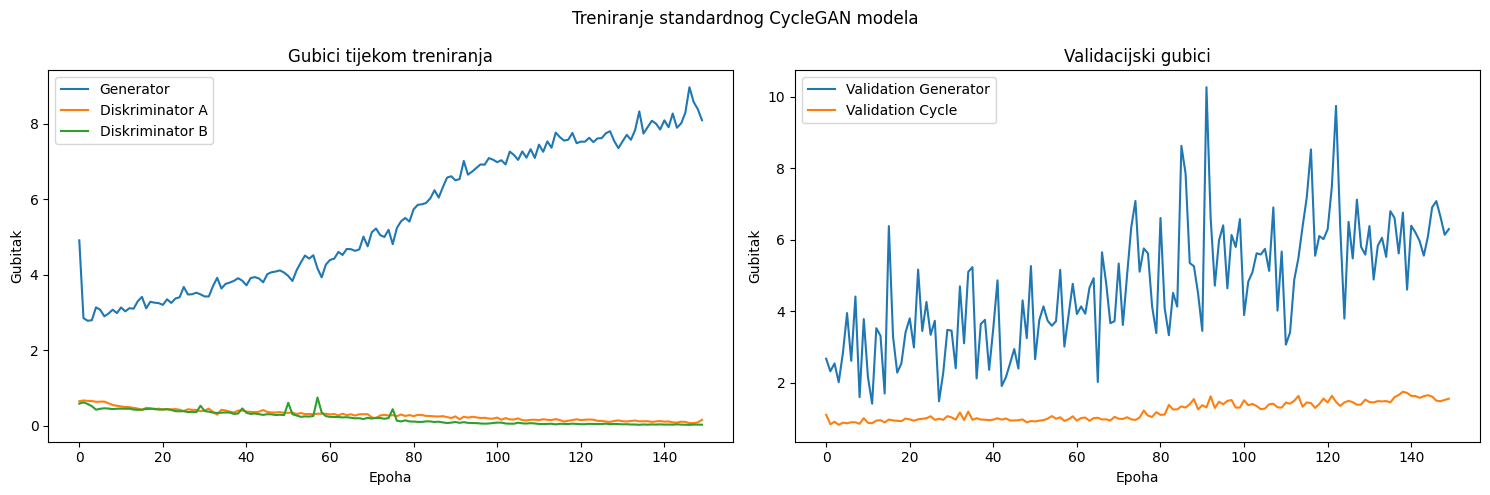

In [8]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [9]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 44/44 [00:02<00:00, 16.05it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7104
  MSE: 0.014433
  PSNR: 18.48 dB

T2 -> T1 translacija:
  SSIM: 0.8288
  MSE: 0.005638
  PSNR: 22.68 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8138
  MSE: 0.004951
  PSNR: 23.20 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7430
  MSE: 0.013828
  PSNR: 18.67 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5317
  MSE: 0.023839
  PSNR: 16.30 dB

T2 -> T1 translacija:
  SSIM: 0.7242
  MSE: 0.009312
  PSNR: 20.50 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.6906
  MSE: 0.008177
  PSNR: 21.02 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.5730
  MSE: 0.022840
  PSNR: 16.49 dB


Vizualizacija rezultata na test setu:


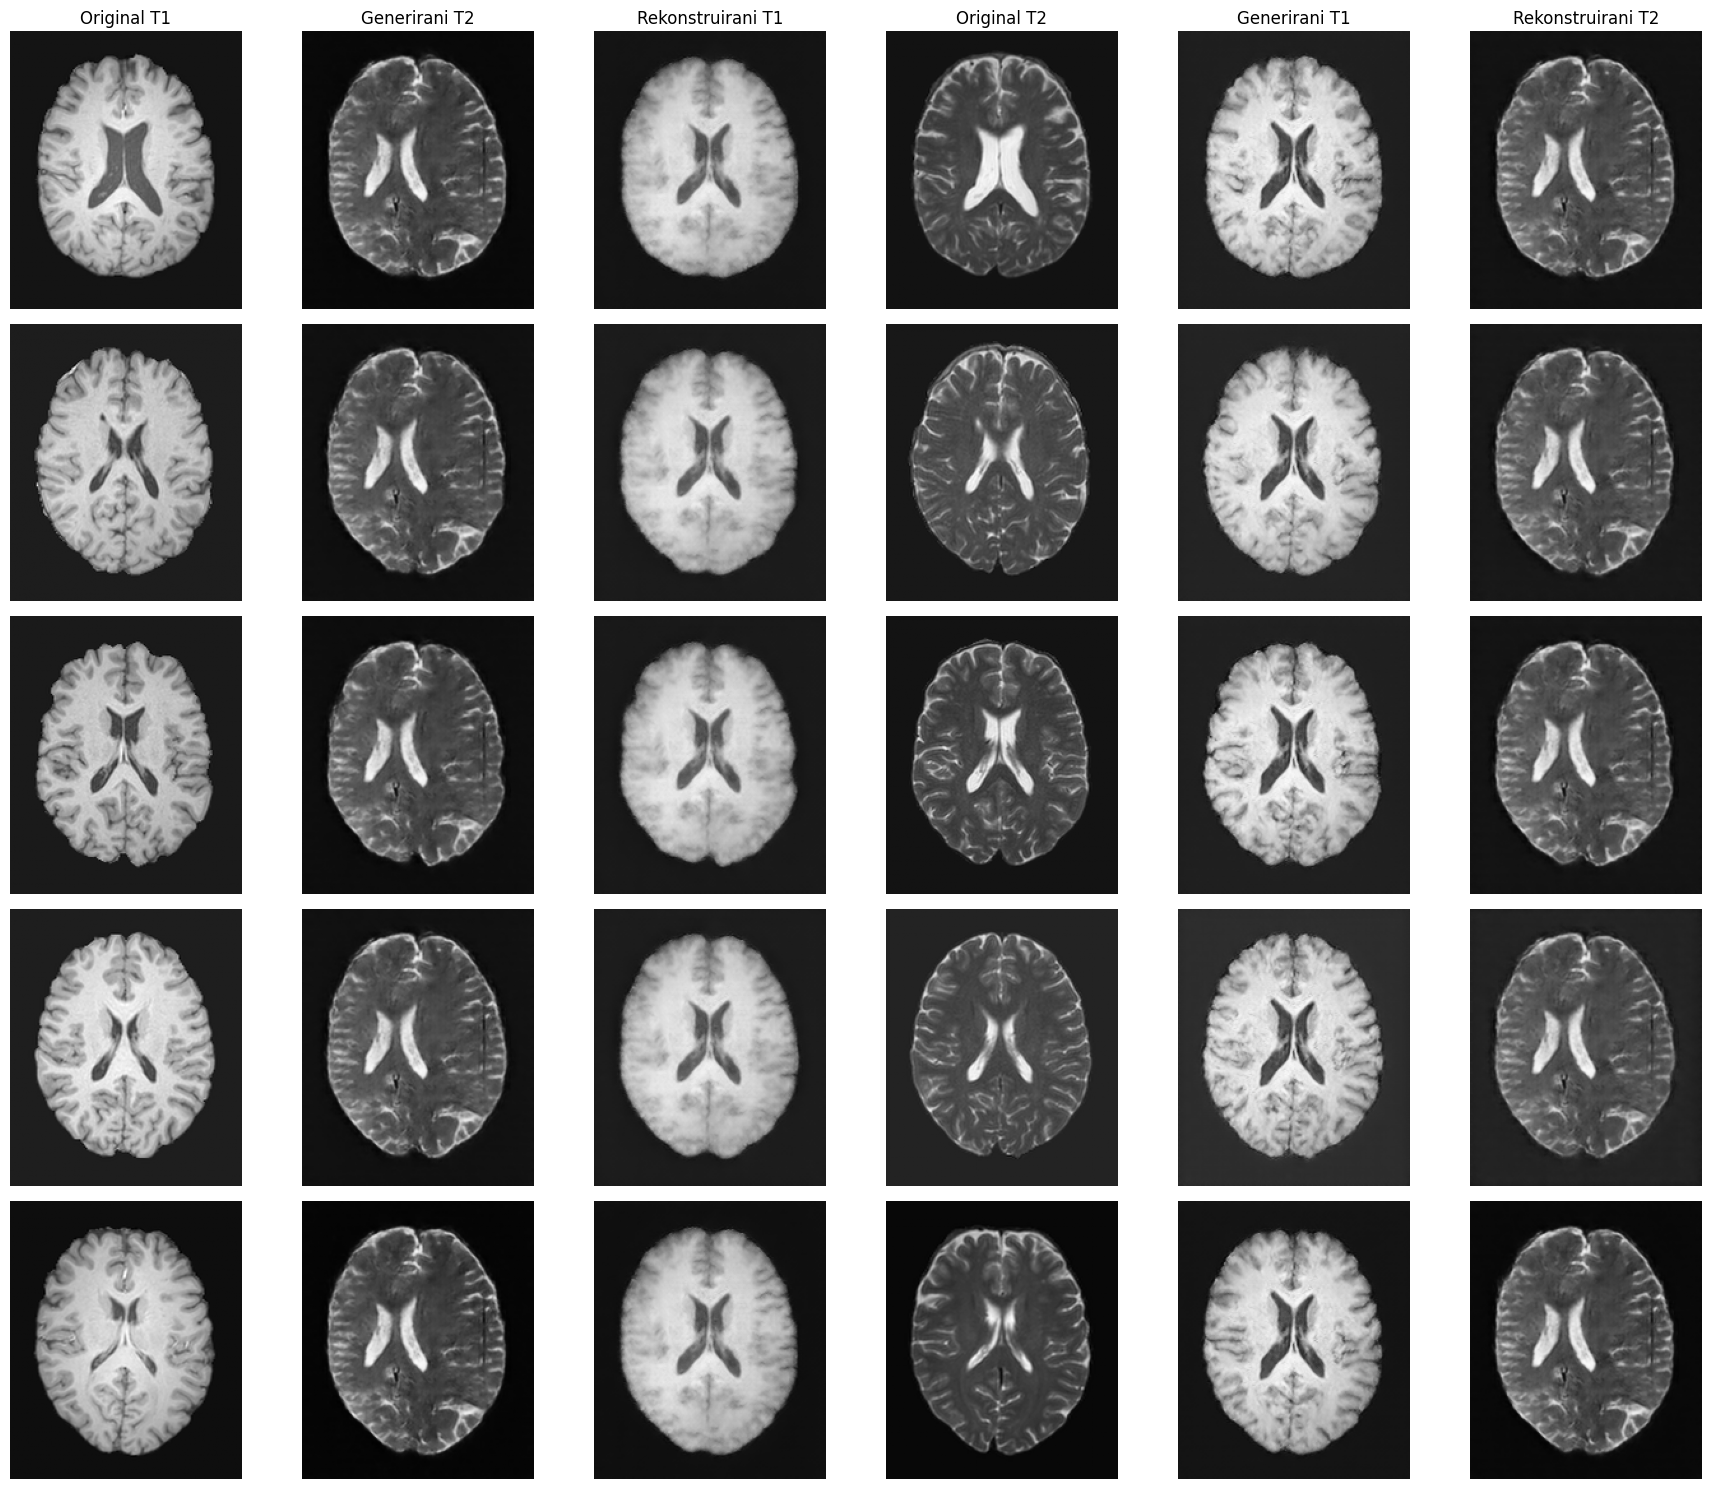

In [10]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=5, config=config)

In [16]:
best_G_AB_cycle = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_cycle = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_cycle = f"{config.checkpoints_dir}/G_AB_cycle_best.pth"
best_G_BA_path_cycle = f"{config.checkpoints_dir}/G_BA_cycle_best.pth"
best_G_AB_cycle.load_state_dict(torch.load(best_G_AB_path_cycle, map_location=config.device))
best_G_BA_cycle.load_state_dict(torch.load(best_G_BA_path_cycle, map_location=config.device))

<All keys matched successfully>

In [17]:
print("Testiranje najboljih cyclce modela:")
test_model(best_G_AB_cycle, best_G_BA_cycle, test_dataloader, config)

Testiranje najboljih cyclce modela:


Evaluacija modela: 100%|██████████| 44/44 [00:03<00:00, 11.31it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.6714
  MSE: 0.015043
  PSNR: 18.36 dB

T2 -> T1 translacija:
  SSIM: 0.6774
  MSE: 0.015125
  PSNR: 18.30 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9004
  MSE: 0.001623
  PSNR: 27.99 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8672
  MSE: 0.002230
  PSNR: 26.75 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.4806
  MSE: 0.024844
  PSNR: 16.18 dB

T2 -> T1 translacija:
  SSIM: 0.4749
  MSE: 0.024982
  PSNR: 16.13 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8402
  MSE: 0.002679
  PSNR: 25.81 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7969
  MSE: 0.003680
  PSNR: 24.57 dB


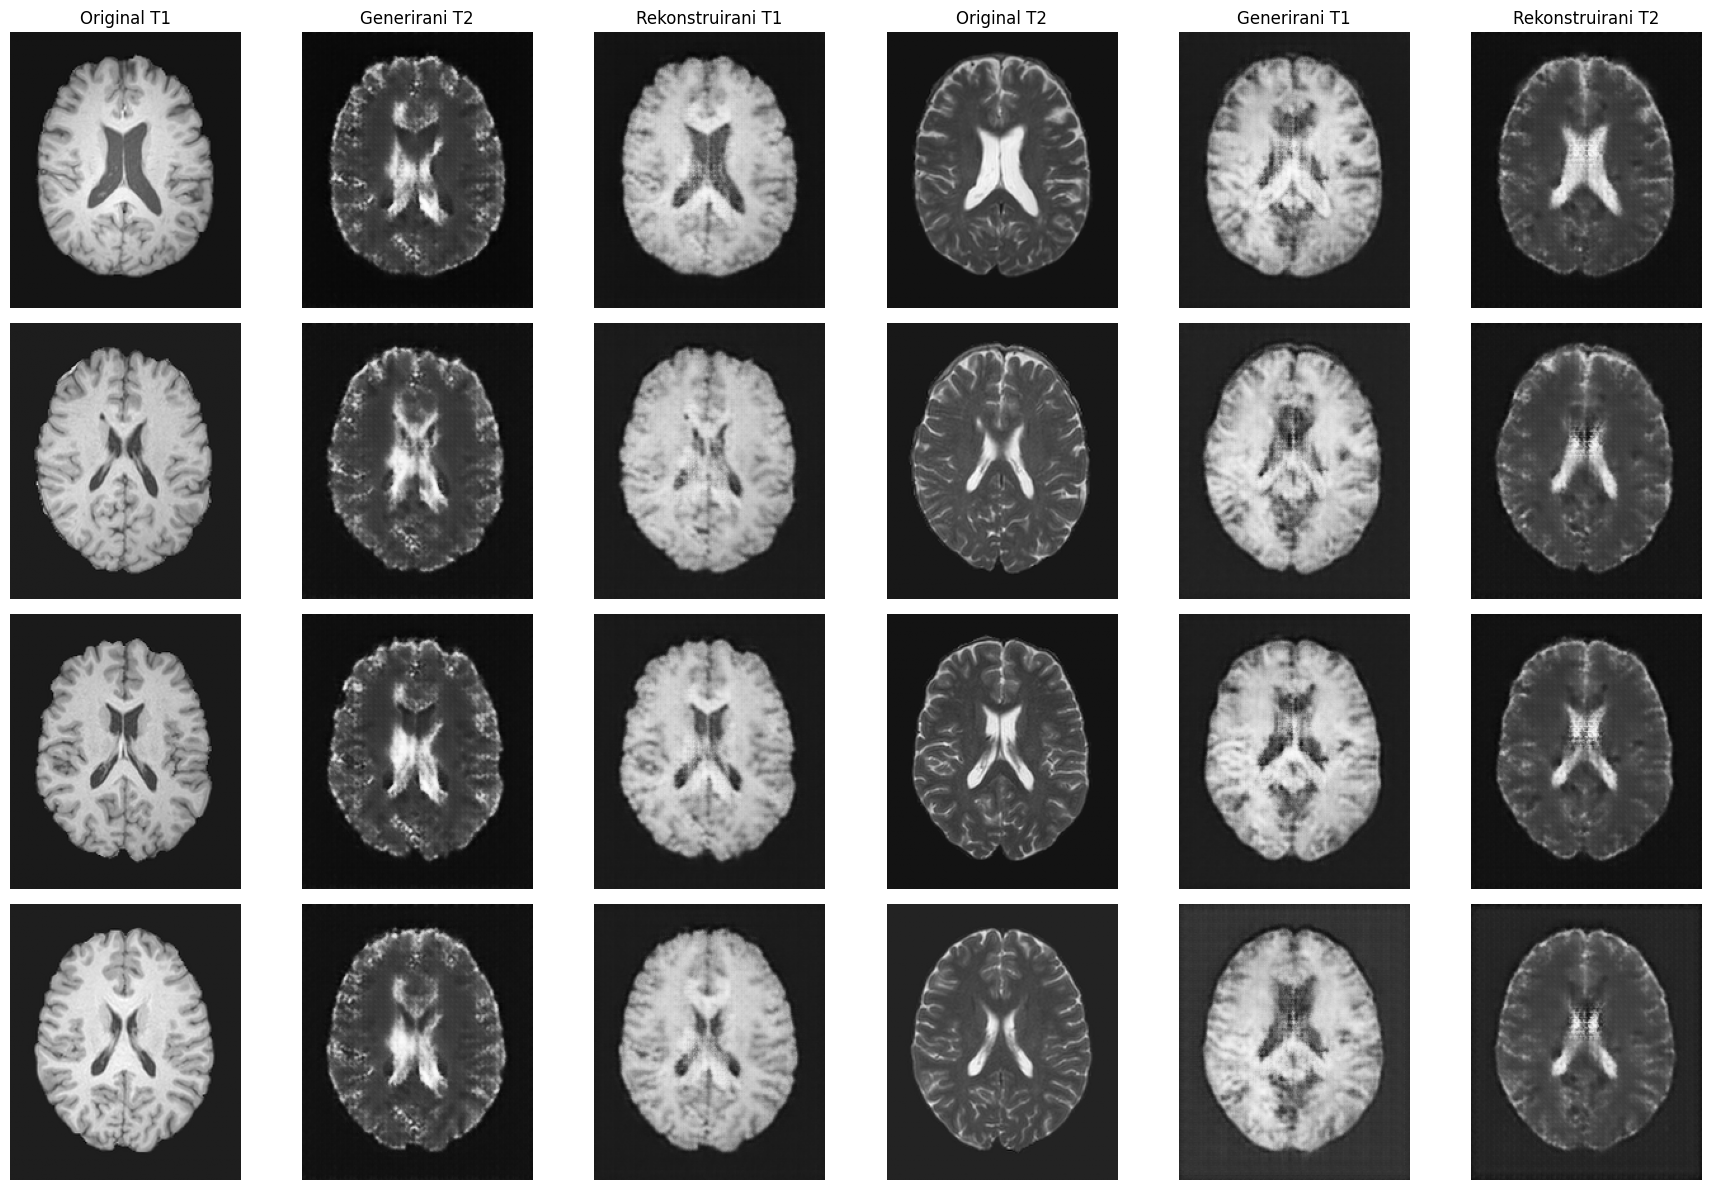

In [13]:
visualize_results(
    best_G_AB_cycle, best_G_BA_cycle, test_dataloader, num_samples=4, config=config
)

In [18]:
best_G_AB_gan = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_gan = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_gan = f"{config.checkpoints_dir}/G_AB_gan_best.pth"
best_G_BA_path_gan = f"{config.checkpoints_dir}/G_BA_gan_best.pth"
best_G_AB_gan.load_state_dict(torch.load(best_G_AB_path_gan, map_location=config.device))
best_G_BA_gan.load_state_dict(torch.load(best_G_BA_path_gan, map_location=config.device))

<All keys matched successfully>

In [19]:
print("Testiranje najboljih cyclce modela:")
test_model(best_G_AB_gan, best_G_BA_gan, test_dataloader, config)

Testiranje najboljih cyclce modela:


Evaluacija modela: 100%|██████████| 44/44 [00:03<00:00, 11.33it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7316
  MSE: 0.009918
  PSNR: 20.25 dB

T2 -> T1 translacija:
  SSIM: 0.7475
  MSE: 0.008020
  PSNR: 21.16 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9057
  MSE: 0.002069
  PSNR: 26.92 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8825
  MSE: 0.003506
  PSNR: 24.77 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5701
  MSE: 0.016381
  PSNR: 18.07 dB

T2 -> T1 translacija:
  SSIM: 0.5870
  MSE: 0.013247
  PSNR: 18.99 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8447
  MSE: 0.003417
  PSNR: 24.74 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8124
  MSE: 0.005789
  PSNR: 22.59 dB
